In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Feb  8 12:35:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 32%   51C    P2             112W / 450W |   5669MiB / 24564MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [5]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.min_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [6]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 16
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.z_activation = F.tanh

In [7]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.11407470703125
encoder.convs 5.989013671875
encoder.linear 0.12506103515625
prior 0.0
latent 0.0
decoder 6.153697967529297
decoder.linear 0.1328125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [8]:
save_dir = '/data/scpark/save/lse/train02.02-8/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


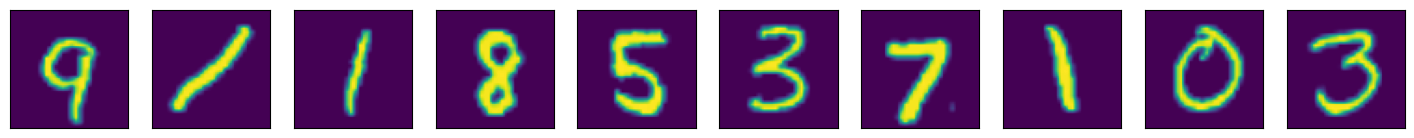

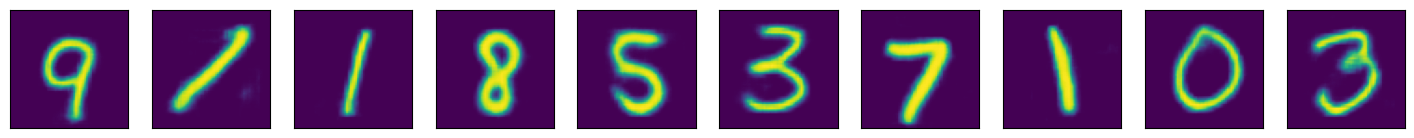

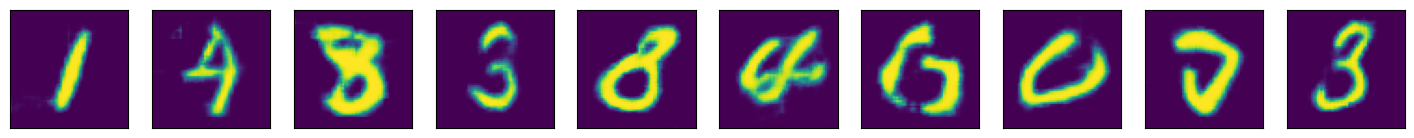

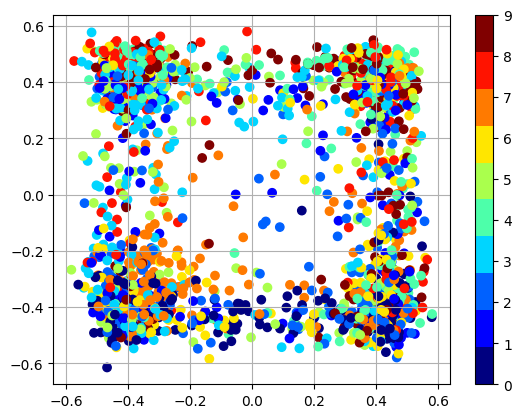

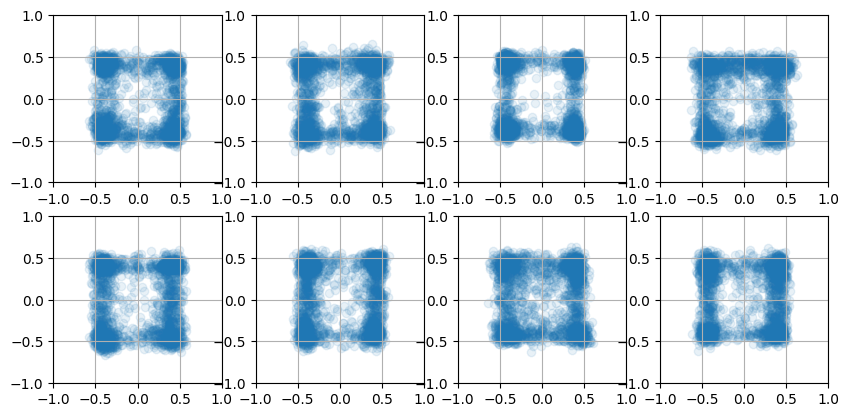

29001
lse_loss 3.025424003601074
recon_loss 0.029701149091124535
29002
lse_loss 3.4732277393341064
recon_loss 0.030423479154706
29003
lse_loss 3.04046630859375
recon_loss 0.027065638452768326
29004
lse_loss 3.005532741546631
recon_loss 0.026329180225729942
29005
lse_loss 3.045106887817383
recon_loss 0.027404826134443283
29006
lse_loss 3.0030250549316406
recon_loss 0.027997981756925583
29007
lse_loss 2.99656343460083
recon_loss 0.02676672302186489
29008
lse_loss 3.049168109893799
recon_loss 0.02603067457675934
29009
lse_loss 3.037537097930908
recon_loss 0.026048801839351654
29010
lse_loss 3.052114963531494
recon_loss 0.025754829868674278
29011
lse_loss 2.999462604522705
recon_loss 0.026502426713705063
29012
lse_loss 3.0096182823181152
recon_loss 0.025452010333538055
29013
lse_loss 3.0140750408172607
recon_loss 0.02539740316569805
29014
lse_loss 2.9996118545532227
recon_loss 0.027188075706362724
29015
lse_loss 3.049933910369873
recon_loss 0.027393637225031853
29016
lse_loss 3.01956224441

29127
lse_loss 2.995302677154541
recon_loss 0.027204472571611404
29128
lse_loss 3.0354583263397217
recon_loss 0.026581227779388428
29129
lse_loss 3.0290770530700684
recon_loss 0.027305468916893005
29130
lse_loss 3.0504891872406006
recon_loss 0.02791788801550865
29131
lse_loss 3.0277791023254395
recon_loss 0.026161393150687218
29132
lse_loss 3.0504696369171143
recon_loss 0.025510624051094055
29133
lse_loss 2.9864656925201416
recon_loss 0.025862369686365128
29134
lse_loss 3.0249857902526855
recon_loss 0.027569938451051712
29135
lse_loss 3.0164952278137207
recon_loss 0.027730613946914673
29136
lse_loss 2.99810528755188
recon_loss 0.028182057663798332
29137
lse_loss 2.994382381439209
recon_loss 0.02600395306944847
29138
lse_loss 3.0291378498077393
recon_loss 0.026090135797858238
29139
lse_loss 3.049640655517578
recon_loss 0.02755487523972988
29140
lse_loss 3.0407958030700684
recon_loss 0.02885126881301403
29141
lse_loss 3.0501463413238525
recon_loss 0.026618538424372673
29142
lse_loss 3.02

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=hp.M)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)
    
import matplotlib.pyplot as plt
_z = data['z'].data.cpu().numpy()
plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
plt.grid()
plt.colorbar()
plt.show()